## AdaptVision Inference Demo


### 1. Setup Environment


In [1]:
!pip install -q torch torchvision transformers accelerate qwen-vl-utils pillow matplotlib

### 2. Load Model
This class encapsulates model loading, image processing, bbox parsing, and the active vision loop.

In [2]:
import torch, json, re
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor, StoppingCriteria, StoppingCriteriaList
from qwen_vl_utils import process_vision_info, smart_resize
# --- Prompts ---
SYSTEM_PROMPT_TOOL = """You are a helpful assistant.
# Tools
<tools>
{"type": "function", "function": {"name_for_human": "request_local_region", "name": "request_local_region", "description": "Request a high-resolution local region of the current image and zoom in", "parameters": {"properties": {"bbox_2d": {"type": "array", "items":{"type":"integer"}, "minItems":4, "maxItems":4, "description": "Absolute pixel coordinates [x1, y1, x2, y2]."}}, "required": ["bbox_2d"], "type": "object"}, "args_format": "Format the arguments as a JSON object."}}
</tools>
Return function calls within <tool_call> tags: <tool_call>{"name": "func_name", "arguments": {...}}</tool_call>
"""
# User Question Template
USER_PROMPT_TEMPLATE = "Answer the question based on the image provided. You must conduct reasoning within <think> and </think> first in each of your reasoning steps. You may call ONE function tool per step to help you better solve the problem. Place the function tool within <tool_call> and </tool_call> at the end of each step to perform a function call. You should continue your reasoning process within <think> and </think> based on the content returned by the function tool. Once you confirm your final answer, place the final answer inside <answer> and </answer>. Here is the image and question:\n{Question}"

# Next Turn Prompt (After tool execution)
IMAGE_CROP_TOOL_CALL_MULTI_TURN_PROMPT = "Please carefully analyze the content returned from the request_local_region tool in combination with the original question and image from the user, continue your reasoning process inside <think> and </think> and then write your final answer inside <answer> and </answer>."


/data/lyc/miniforge3/envs/adaptvision/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

class KeywordStoppingCriteria(StoppingCriteria):
    def __init__(self, token_ids):
        self.token_ids = token_ids

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        # Check if the last generated tokens match the stop sequence
        # We assume batch_size=1
        if input_ids.shape[1] >= len(self.token_ids):
            return input_ids[0, -len(self.token_ids):].tolist() == self.token_ids
        return False
    


class AdaptVision:
    def __init__(self, model_path="AdaptVision/AdaptVision-7B", device="cuda"):
        print("Loading Models...")
        self.model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
            model_path, torch_dtype=torch.bfloat16, device_map=device
        )
        self.processor = AutoProcessor.from_pretrained(model_path)
        self.device = device
        self.ds_factor = 2 # Downsample factor for global view
        
        stop_str = "</tool_call>"
        self.stop_token_ids = self.processor.tokenizer.encode(stop_str, add_special_tokens=False)
        print(f"Stop tokens for '{stop_str}': {self.stop_token_ids}")

    def _resize_img(self, img, factor=1, max_pixels=2048*2048):
        """Resize image to fit Qwen input requirements."""
        w, h = img.size
        img = img.resize((max(28, w // factor), max(28, h // factor)), Image.Resampling.LANCZOS)
        h, w = smart_resize(img.height, img.width, factor=28, min_pixels=4*28*28, max_pixels=max_pixels)
        return img.resize((w, h), Image.Resampling.LANCZOS)

    def _extract_bbox(self, text, img_size):
        """Extract BBox from response and restore absolute coordinates."""
        match = re.search(r"<tool_call>(.*?)</tool_call>", text, re.DOTALL)
        if not match: return None
        try:
            bbox = json.loads(match.group(1))["arguments"]["bbox_2d"]
            # Restore coordinates (since input was downsampled)
            scale = self.ds_factor
            W, H = img_size[0] * scale, img_size[1] * scale
            return [max(0, min(int(c * scale), limit)) for c, limit in zip(bbox, [W, H, W, H])]
        except: return None

    def run(self, image_path, question, max_rounds=2):
        raw_img = Image.open(image_path).convert("RGB") if isinstance(image_path, str) else image_path.convert("RGB")
        
        print("Original Image Size:", raw_img.size)
        # 1. Generate Global View (Downsampled)
        global_img = self._resize_img(raw_img, factor=self.ds_factor)
        
        print("Downsampled Image Size:", global_img.size)
        question = USER_PROMPT_TEMPLATE.format(Question=question)
        
        msgs = [
            {"role": "system", "content": SYSTEM_PROMPT_TOOL},
            {"role": "user", "content": [{"type": "image", "image": global_img}, {"type": "text", "text": question}]}
        ]
        
        history = {"bboxes": [], "crops": [global_img], "final_ans": "", "raw_img": raw_img}
        
        stop_criteria = StoppingCriteriaList([KeywordStoppingCriteria(self.stop_token_ids)])
        st_time = time.time()
        # 2. Inference Loop
        for i in range(max_rounds):
            print(f"--- Round {i+1} ---")
            
            # Generate
            text_prompt = self.processor.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True)
            image_inputs, video_inputs = process_vision_info(msgs)
            inputs = self.processor(text=[text_prompt], images=image_inputs, videos=video_inputs, padding=True, return_tensors="pt").to(self.device)
            
            out_ids = self.model.generate(**inputs, max_new_tokens=2048, temperature=0, top_p=0.95, stopping_criteria=stop_criteria)
            response = self.processor.batch_decode(out_ids[:, inputs.input_ids.shape[1]:], skip_special_tokens=True)[0]
            print(f"Model: {response[:1500]}...")
            
            msgs.append({"role": "assistant", "content": response})
            
            # Check Tool Call
            bbox = self._extract_bbox(response, global_img.size)
            if bbox:
                print(f"Tool Call: Cropping {bbox}")
                history["bboxes"].append(bbox)
                
                # Crop High-Res from Raw Image
                crop = self._resize_img(raw_img.crop(bbox), factor=1, max_pixels=3840*3840)
                
                print("Cropped Image Size:", crop.size)
                history["crops"].append(crop)
                
                msgs.append({"role": "user", "content": [
                    {"type": "text", "text": "<tool_response>\nThe cropped region of the image is shown below:\n"},
                    {"type": "image", "image": crop},
                    {"type": "text", "text": "\n</tool_response>\n" + IMAGE_CROP_TOOL_CALL_MULTI_TURN_PROMPT}
                ]})
            else:
                history["final_ans"] = response
                break
        end_time = time.time()
        print(f"Total Inference Time: {end_time - st_time:.2f} seconds")
                
        return history

### 3. Run Inference

In [10]:
# Initialize
bot = AdaptVision()

# Prepare image and question
image_path = "../assets/test_img2.png"
question = "Is there a stop sign facing us?"

Loading Models...


Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]


Stop tokens for '</tool_call>': [151658]


In [16]:
# Run
result = bot.run(image_path, question)

Original Image Size: (1448, 938)
Downsampled Image Size: (728, 476)
--- Round 1 ---
Model: <think>Upon examining the image, there is a sign visible on the right side of the road, but it is not clearly identifiable as a stop sign. To determine if it is a stop sign, I need to zoom in on that area.</think>
<tool_call>{"name": "request_local_region", "arguments": {"bbox_2d": [418, 189, 440, 214]}}</tool_call>...
Tool Call: Cropping [836, 378, 880, 428]
Cropped Image Size: (56, 56)
--- Round 2 ---
Model: <think>The image shows a stop sign. Therefore, the answer to the question is yes, there is a stop sign facing us.</think>
<answer>Yes, there is a stop sign facing us.</answer>...
Total Inference Time: 2.08 seconds


### 4. Visualization

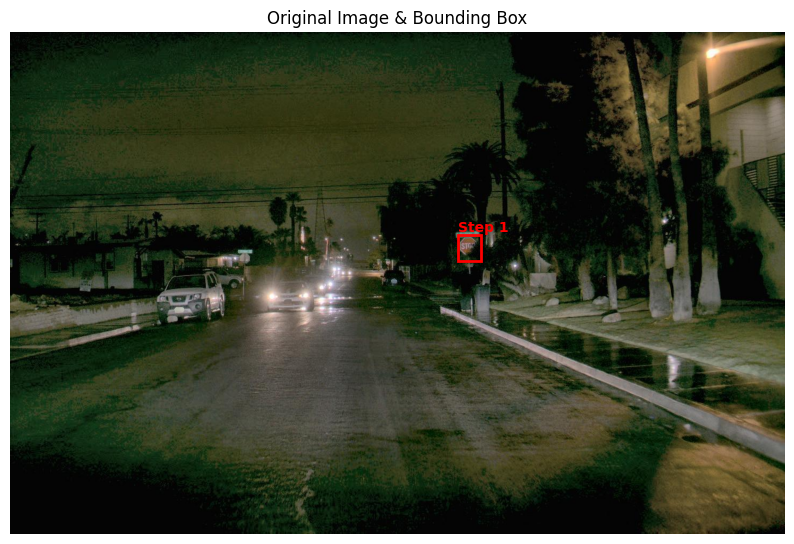

Zoomed-in Views:


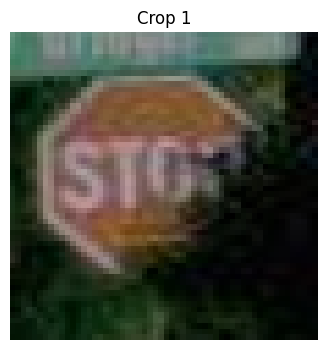

In [9]:
def show_result(res):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(res["raw_img"])
    ax.set_title("Original Image & Bounding Box")
    
    # Draw BBox
    for i, box in enumerate(res["bboxes"]):
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(box[0], box[1]-5, f'Step {i+1}', color='red', weight='bold')
    plt.axis('off'); plt.show()

    # Draw cropped views
    if len(res["crops"]) > 1:
        print("Zoomed-in Views:")
        fig, axes = plt.subplots(1, len(res["crops"])-1, figsize=(12, 4))
        if not isinstance(axes, np.ndarray): axes = [axes]
        for ax, img, i in zip(axes, res["crops"][1:], range(1, 99)):
            ax.imshow(img); ax.set_title(f"Crop {i}"); ax.axis('off')
        plt.show()

show_result(result)

### 5. Comparison with Qwen

In [17]:
class QwenVL:
    def __init__(self, model_path="Qwen/Qwen2.5-VL-7B-Instruct", device="cuda:1"):
        print("Loading Models...")
        self.model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
            model_path, torch_dtype=torch.bfloat16, device_map=device
        )
        self.processor = AutoProcessor.from_pretrained(model_path)
        self.device = device
        
    def _resize_img(self, img, factor=1, max_pixels=2048*2048):
        """Resize image to fit Qwen input requirements."""
        w, h = img.size
        img = img.resize((max(28, w // factor), max(28, h // factor)), Image.Resampling.LANCZOS)
        h, w = smart_resize(img.height, img.width, factor=28, min_pixels=4*28*28, max_pixels=max_pixels)
        return img.resize((w, h), Image.Resampling.LANCZOS)


    def run(self, image_path, question, downsample=False):
        raw_img = Image.open(image_path).convert("RGB") if isinstance(image_path, str) else image_path.convert("RGB")
        
        print("Original Image Size:", raw_img.size)
        # 1. Generate Global View (Downsampled)
        if downsample:
            global_img = self._resize_img(raw_img, factor=2)
        else:
            global_img = self._resize_img(raw_img, factor=1)
        
        print("Input Image Size:", global_img.size)
        question = question
        
        msgs = [
            {"role": "user", "content": [{"type": "image", "image": global_img}, {"type": "text", "text": question}]}
        ]

        # 2. Inference 
        st_time = time.time()
        text_prompt = self.processor.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True)
        image_inputs, video_inputs = process_vision_info(msgs)
        inputs = self.processor(text=[text_prompt], images=image_inputs, videos=video_inputs, padding=True, return_tensors="pt").to(self.device)
            
        out_ids = self.model.generate(**inputs, max_new_tokens=2048)
        response = self.processor.batch_decode(out_ids[:, inputs.input_ids.shape[1]:], skip_special_tokens=True)[0]
        end_time = time.time()
        print(f"Total Inference Time: {end_time - st_time:.2f} seconds")
        print(f"Model: {response[:1500]}...")
                   
        return response

In [19]:
# Initialize
qwen_vanilla = QwenVL()
# Prepare image and question
image_path = "../assets/test_img2.png"
question = "Is there a stop sign facing us?"

Loading Models...


Loading checkpoint shards: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


#### Original Image

In [20]:
# Run
result = qwen_vanilla.run(image_path, question, downsample=False)

Original Image Size: (1448, 938)
Input Image Size: (1456, 952)
Total Inference Time: 1.96 seconds
Model: Yes, there is a stop sign visible in the image, and it is facing towards the viewer. It is located on the right side of the street, near the sidewalk, and is partially obscured by trees. The sign is red with white lettering that reads "STOP."...


#### Downsampled Image (1/4 pixels)

In [21]:

result2 = qwen_vanilla.run(image_path, question, downsample=True)

Original Image Size: (1448, 938)
Input Image Size: (728, 476)
Total Inference Time: 1.70 seconds
Model: No, there is no stop sign facing the camera in this image. The image shows a street at night with cars driving away from the viewer and a sidewalk on the right side. There are trees lining the sidewalk, and the street appears to be wet, possibly from recent rain. The stop sign is not visible in the frame of the image....
